In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import pickle
import glob
from sklearn.utils import shuffle
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import cv2
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
from keras.models import model_from_json
import json

Using TensorFlow backend.


## Load Dataset

()


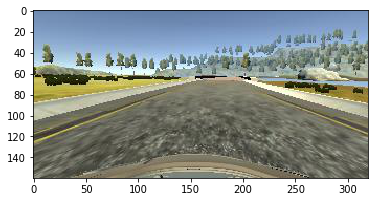

-0.05975719
0.05975719


In [2]:
import random as rand

img_dir = '/home/carnd/CarND-Behaviour-Clonning/data/'
data_csv_dir = '/home/carnd/CarND-Behaviour-Clonning/data/'
data_csv_name = 'driving_log.csv'

col_names = ['center', 'left','right','steering','throttle','brake','speed']

training_data = pd.read_csv(data_csv_dir + data_csv_name, names = col_names)
training_data.head()
line_data = training_data.iloc[[100]].reset_index()
numSample = training_data.shape[0]

imgLocation = img_dir  + training_data['center'][49]
steer = np.array(line_data['steering'][0])
print(steer.shape)
img = mpimg.imread(imgLocation)

plt.imshow(img)
plt.show()
print(steer)
steer = np.asarray(-1 * steer)
print(steer)

8036
(160, 320, 3)


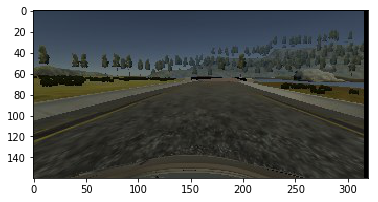

In [3]:
path = line_data['center'][0]

imgLocation = img_dir  + str(np.char.strip(path))
image = mpimg.imread(imgLocation)

lenx = image.shape[0]
leny = image.shape[1]
#image = cv2.resize(image, (int(leny/2), int(lenx/2)))
#image = image = cv2.flip(image, 1)

h, w, ch = image.shape

pts1 = np.float32([[0, 0], [w, 0], [w, h]])
a = 0
shift = 10

shiftx = rand.randint(- shift, shift)
shifty = rand.randint(- shift / 2, shift / 2)

pts2 = np.float32([[
    0 + rand.randint (- a, a) + shiftx,
    0 + rand.randint (- a, a) + shifty,
],[
    w + rand.randint (- a, a) + shiftx,
    0 + rand.randint (- a, a) + shifty,
],[
    w + rand.randint (- a, a) + shiftx,
    h + rand.randint (- a, a) + shifty,
]])

M = cv2.getAffineTransform(pts1, pts2)

image = cv2.warpAffine(img, M, (w, h))

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
randomLight = 0.25 + np.random.rand() 
hsv[:,:,2] =  hsv[:,:,2] * randomLight
image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        
print(len(training_data))    
print(image.shape)

plt.imshow(image)
plt.show()

## Data Visualization

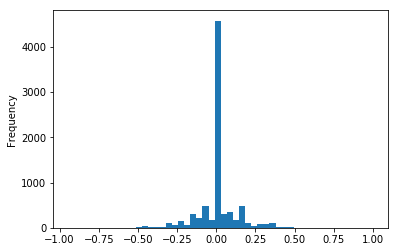

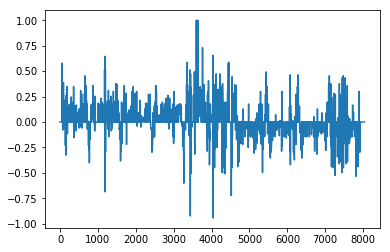

In [4]:
training_data['steering'].plot.hist(bins=50)
plt.show()

plt.plot(training_data['steering'])
plt.show()

## Filter Useless Repeated Data Out

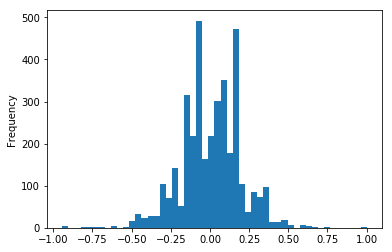

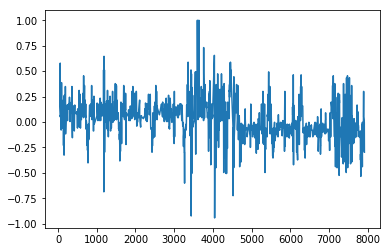

(3675, 7)


In [5]:
from collections import deque

def filter_driving_straight(data_df, hist_items=6):
    steering_history = deque([])
    
    drop_rows=[]
    
    for idx, row in data_df.iterrows():
        # controls = [getattr(row, control) for control in vehicle_controls]
        steering = getattr(row, 'steering')
        
        # record the recent steering history
        steering_history.append(steering)
        if len(steering_history) > hist_items:
            steering_history.popleft()

        # if just driving in a straight line continue
        if steering_history.count(0.0) == hist_items:
            drop_rows.append(idx)

    return data_df.drop(data_df.index[drop_rows])

training_data = filter_driving_straight(training_data, 1)

training_data['steering'].plot.hist(bins=50)
plt.show()

plt.plot(training_data['steering'])
plt.show()

print(training_data.shape)

## Model Architecture

In [6]:
from keras.layers.core import Dropout

def commaai_model(shape):
    
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.,
                input_shape = shape,
                output_shape = shape))
    
    model.add(Convolution2D(16, 8, 8, subsample = (4,4), border_mode = 'same'))
    model.add(ELU(()))
    
    model.add(Convolution2D(32, 5, 5, subsample = (2,2), border_mode = 'same'))
    model.add(ELU(()))    

    model.add(Convolution2D(64, 5, 5, subsample = (2,2), border_mode = 'same'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(ELU(()))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(ELU(()))
    model.add(Dense(1))
    model.add(Activation('softmax'))

    model.compile(optimizer = 'adam', loss = 'mse')
    
    return model

def nvidia_model(shape):
    
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.,
                input_shape = shape,
                output_shape = shape))
    
    #conv layers with dropout
    nb_filters = [24, 36, 48, 64, 64]
    kernel_size = [(5, 5), (5, 5), (5, 5), (3, 3), (3, 3)]
    same, valid = ('same', 'valid')
    padding = [valid, valid, valid, valid, valid]
    strides = [(2, 2), (2, 2), (2, 2), (1, 1), (1, 1)]
    dropout = 0.5
    
    for lyr in range(len(nb_filters)):
        model.add(Convolution2D(nb_filters[lyr],
                                kernel_size[lyr][0],
                                kernel_size[lyr][1],
                                subsample = strides[lyr],
                                border_mode = 'valid',
                                activation = 'elu'))

        model.add(Dropout(dropout))
                  
    #flatten layer
    model.add(Flatten())
    
    #fully connected layers with dropout
    neurons = [100, 50, 10]
    for l in range(len(neurons)):
        model.add(Dense(neurons[l], activation = 'elu'))
        model.add(Dropout(dropout))
        
    #logit output - steering angle
    model.add(Dense(1, activation = 'elu', name = 'Out'))
    model.add(Activation('softmax'))

    model.compile(optimizer = 'adam', loss = 'mse')
    
    return model

## Save Model

In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LambdaCallback, Callback
from pathlib import Path
import json

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    model.save_weights(fileWeights)

## Preprocess Batch

In [8]:
def preprocess_train(line_data):

    random_choice = np.random.randint(3)

    if random_choice == 0:
        path = line_data['center'][0]
        steeringAngle = np.array([[line_data['steering'][0]]])
        steer = steeringAngle[0] 
        
    if random_choice == 1:
        path = line_data['left'][0]
        steeringAngle = np.array([[line_data['steering'][0]]])
        steer = steeringAngle[0] + 0.25
        
    if random_choice == 2:
        path = line_data['right'][0]
        steeringAngle = np.array([[line_data['steering'][0]]])
        steer = steeringAngle[0] - 0.25
        
    imgLocation = img_dir  + str(np.char.strip(path))
    image = mpimg.imread(imgLocation)
    
    if np.random.randint(0.5) < 1:

        image = cv2.flip(image, 1)
        steer = -1 * steeringAngle[0]
    
    if np.random.randint(0.5) < 1:
        #right curve: positive increase
        #left curve: negative decrease

        h, w, ch = image.shape

        pts1 = np.float32([[0, 0], [w, 0], [w, h]])
        a = 0
        shift = 10

        shiftx = rand.randint(- shift, shift)
        shifty = rand.randint(- shift / 2, shift / 2)

        pts2 = np.float32([[
            0 + rand.randint (- a, a) + shiftx,
            0 + rand.randint (- a, a) + shifty,
        ],[
            w + rand.randint (- a, a) + shiftx,
            0 + rand.randint (- a, a) + shifty,
        ],[
            w + rand.randint (- a, a) + shiftx,
            h + rand.randint (- a, a) + shifty,
        ]])

        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(img, M, (w, h))
        steer = shiftx * 0.00625 + steeringAngle[0]
        
    if np.random.randint(2) < 1:
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        randomLight = 0.25 + np.random.rand() 
        hsv[:,:,2] =  hsv[:,:,2] * randomLight
        image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return image, steer    

def preprocess_val(line_data):
    path = line_data['center'][0]
    steeringAngle = np.array([[line_data['steering'][0]]])
    steer = steeringAngle[0] 
    imgLocation = img_dir  + str(np.char.strip(path))
    image = mpimg.imread(imgLocation)
    return image, steer  

## Generator

In [9]:
def generateBatch_Train(data, batchSize = 32):
    
    while True:
        batchX = np.zeros((batchSize, 160, 320, 3),dtype = float)
        batchy = np.zeros((batchSize, 1),dtype=float)
        
        for i_batch in range(batchSize):
            
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            X, y = preprocess_train(line_data)
            
            batchX[i_batch] = X
            batchy[i_batch] = y
        
        yield batchX, batchy

def generateBatch_Val(data):
    
    while True:
        batchX = np.zeros((1, 160, 320, 3),dtype = float)
        batchy = np.zeros((1, 1),dtype=float)
        
        i_line = np.random.randint(len(data))
        line_data = data.iloc[[i_line]].reset_index()
        
        X, y = preprocess_val(line_data)
        
        #X = X.reshape(1, X.shape[0], X.shape[1], X.shape[2])
        #y = np.array([[y]])
        batchX[0] = X
        batchy[0] = y
        
        yield batchX, batchy

## Train

In [10]:
shape = (160, 320, 3)
#model = commaai_model(shape)
model = nvidia_model(shape)

numTimes = 1
numEpoch = 1
samplesPerEpoch = 40000
nbValSamples = 1000
val_best = 999

for time in range(numTimes):
    #X_train, y_train = shuffle(X_train, y_train)
    #X_validation, y_validation = shuffle(X_validation, y_validation)
    
    trainGenerator = generateBatch_Train(training_data, batchSize = 256)
    validGenerator = generateBatch_Val(training_data)
    
    #history = model.fit(X_train, y_train, nb_epoch=numEpoch, validation_split=0.2)
    history = model.fit_generator(trainGenerator, 
                                  samples_per_epoch = samplesPerEpoch, 
                                  nb_epoch = numEpoch, 
                                  validation_data = validGenerator, 
                                  nb_val_samples = nbValSamples)

    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        val_best = val_loss
        fileModelJSON = 'model_best_last.json'
        fileWeights = 'model_best_last.h5'
        save_model(fileModelJSON,fileWeights)
        
    print('Time: ', time + 1)

Epoch 1/1
39936/40000 [============================>.] - ETA: 0s - loss: 1.0194

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


40192/40000 [==============================] - 235s - loss: 1.0193 - val_loss: 1.0063
Time:  1
